## Grad

In [12]:
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D


# with tf.device('/gpu:3'):
resnet152 = keras.applications
conv_model = resnet152.ResNet152(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224,224, 3),
    include_top=False,)

#     x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
predictions = keras.layers.Dense(3,activation = 'softmax')(x)

model = keras.models.Model(inputs = conv_model.input,outputs =predictions)

model.summary()

#     model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
#                   loss = 'categorical_crossentropy',
#                   metrics = ['accuracy'])
#     history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
#                         validation_data=datagen.flow(test_img,test_label,batch_size =32),
#                         batch_size = 32,
#                         epochs=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
                    validation_data=datagen.flow(test_img,test_label,batch_size =32),
                    batch_size = 32,
                    epochs=10)

model.save("whyisit.h5")

Epoch 1/10
83/83 [==============================] - 43s 520ms/step - loss: 0.8831 - accuracy: 0.5679 - val_loss: 0.9423 - val_accuracy: 0.5569
Epoch 2/10
83/83 [==============================] - 40s 479ms/step - loss: 0.6475 - accuracy: 0.7037 - val_loss: 0.7712 - val_accuracy: 0.6411
Epoch 3/10
83/83 [==============================] - 40s 477ms/step - loss: 0.5376 - accuracy: 0.7579 - val_loss: 0.6940 - val_accuracy: 0.6750
Epoch 4/10
83/83 [==============================] - 39s 473ms/step - loss: 0.4885 - accuracy: 0.7779 - val_loss: 0.6144 - val_accuracy: 0.7164
Epoch 5/10
83/83 [==============================] - 40s 477ms/step - loss: 0.4480 - accuracy: 0.7964 - val_loss: 0.6175 - val_accuracy: 0.7090
Epoch 6/10
83/83 [==============================] - 40s 476ms/step - loss: 0.4087 - accuracy: 0.8154 - val_loss: 0.5744 - val_accuracy: 0.7282
Epoch 7/10
83/83 [==============================] - 40s 478ms/step - loss: 0.3813 - accuracy: 0.8294 - val_loss: 0.5888 - val_accuracy: 0.7371

In [31]:

from keras import layers
from keras import models
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing import image

from keras import backend as K
import cv2

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [27]:
img_path = '../sungjin/tooth3/test/over50/20683260 엄대용 16.png'

image = image_utils.load_img(img_path, target_size=(151, 112))
image = image_utils.img_to_array(image)
image = np.expand_dims(image,axis = 0)
x = preprocess_input(image)

In [28]:
# layer which calculate `score class`
conv_layer = model.get_layer("conv5_block3_3_conv")

In [29]:
from keras import models
heatmap_model = models.Model([model.inputs],[conv_layer.output,model.output])

In [32]:
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(x) # y^c, c
    loss = predictions[:, np.argmax(predictions[0])] # probability
    grads = gtape.gradient(loss, conv_output) # partial-derivative
    pooled_grads = K.mean(grads, axis=(0, 1, 2)) # a_k^c , weight


In [33]:
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # summation weight * filter
heatmap = np.maximum(heatmap, 0) # ReLu
max_heat = np.max(heatmap) # normalization

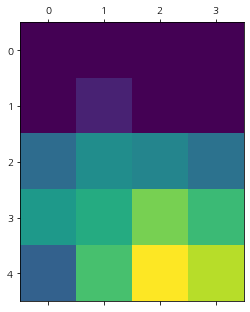

In [34]:

if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat


plt.matshow(heatmap[0])

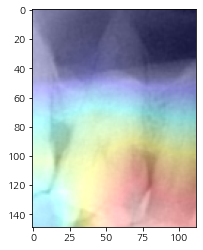

In [39]:
# img = mpimg.imread(img_path)
img = cv2.imread(img_path)
hm = heatmap[0]
hm = cv2.resize(hm, (img.shape[1],img.shape[0]))
hm = np.uint8(255*hm)
hm = cv2.applyColorMap(hm,cv2.COLORMAP_JET)

cvt_heatmap = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

superimposed_img = cvt_heatmap * 0.3 + img

superimposed_img[superimposed_img > 255] = 255
superimposed_img = superimposed_img.astype('uint8')


plt.imshow(superimposed_img)